#  MicroGrad demo

In [1]:
import random
from typing import Callable, List, Tuple

import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import make_moons, make_blobs
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

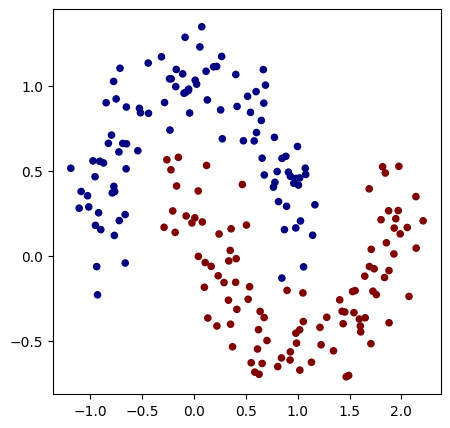

In [4]:
size_of_dataset = 200
noise_of_dataset = 0.15

X, y = make_moons(n_samples=size_of_dataset, noise=noise_of_dataset)

y = y*2 - 1
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
print(X.shape)
print(y.shape)

(200, 2)
(200,)


## MLP with different loss functions

In [6]:
svm_loss_model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(svm_loss_model)
print("number of parameters", len(svm_loss_model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [7]:
mse_loss_model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(mse_loss_model)
print("number of parameters", len(mse_loss_model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


### Average SVM-based loss

In [8]:
def svm_loss(model : MLP, alpha = 1e-4, batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # Forward pass: compute scores using the model
    scores = list(map(model, inputs))
    
    # Compute SVM max-margin loss
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # Compute L2 regularization loss
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    
    total_loss = data_loss + reg_loss
    
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, float(sum(accuracy)) / len(accuracy)


### Traditional MSE

In [9]:
def mse_loss(model : MLP, alpha = 1e-4, batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # Forward the model to get scores
    scores = list(map(model, inputs))
    
    losses = [(scorei - yi)**2 for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    

    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, float(sum(accuracy)) / len(accuracy)

In [10]:
num_epochs = 200
lr = 0.001
l2_penalty_term = 1e-5
batch_size = 20
print_interval = 5

def train_model(
    model: MLP,
    loss_func: Callable[[MLP, float, int], Tuple[Value, float]],
    num_epochs: int,
    lr: float,
    l2_penalty: float,
    batch_size: int = batch_size,
    print_interval: int = print_interval
) -> Tuple[List[float], List[float]]:
    """
    Trains a multi-layer perceptron (MLP) model using stochastic gradient descent (SGD).

    Args:
        model (MLP): The neural network model to be trained.
        loss_func (Callable[[MLP, float, int], Tuple[Value, float]]): 
            A function that computes the total loss and accuracy. 
            Signature: `loss_func(model, alpha, batch_size) -> (total_loss, accuracy)`.
        num_epochs (int): Number of training epochs.
        lr (float): Initial learning rate for SGD.
        l2_penalty (float): L2 regularization penalty term.
        batch_size (int, optional): Batch size for training. Defaults to 32.
        print_interval (int, optional): Number of epochs between progress printouts. Defaults to 2.

    Returns:
        Tuple[List[float], List[float]]: 
            - A list of total loss values (`total_loss.data`) for each epoch.
            - A list of accuracies for each epoch.
    """
    losses: List[float] = []
    accuracies: List[float] = []

    for epoch in range(num_epochs):
        # Compute the loss and accuracy for the current batch
        total_loss, acc = loss_func(model, l2_penalty, batch_size)
        
        # Zero the gradients
        model.zero_grad()
        total_loss.backward()
        
        
        learning_rate = lr if (loss_func == mse_loss) else (1 - 0.9*lr*epoch)  # Decaying learning rate
        for p in model.parameters():
            p.data -= learning_rate * p.grad
        
        # Store the loss and accuracy for plotting
        losses.append(total_loss.data)
        accuracies.append(acc)
        
        # Print progress at intervals
        if (epoch + 1) % print_interval == 0:
            print(f"[{epoch + 1}/{num_epochs}], Loss: {total_loss.data:.3f}, Accuracy: {acc * 100:.2f}%")

    return losses, accuracies


In [11]:
print("Training on MSE loss + Flat LR: ")
mse_losses, mse_accuracies = train_model(mse_loss_model, mse_loss, num_epochs, lr, l2_penalty_term)
print("")
print("Training on SVM loss + Decaying LR: ")
svm_losses, svm_accuracies = train_model(svm_loss_model, svm_loss, num_epochs, lr, l2_penalty_term)

Training on MSE loss + Flat LR: 
[5/200], Loss: 1.453, Accuracy: 30.00%
[10/200], Loss: 1.435, Accuracy: 45.00%
[15/200], Loss: 1.287, Accuracy: 55.00%
[20/200], Loss: 1.315, Accuracy: 65.00%
[25/200], Loss: 1.272, Accuracy: 50.00%
[30/200], Loss: 0.933, Accuracy: 65.00%
[35/200], Loss: 0.717, Accuracy: 75.00%
[40/200], Loss: 0.880, Accuracy: 65.00%
[45/200], Loss: 0.799, Accuracy: 65.00%
[50/200], Loss: 1.034, Accuracy: 45.00%
[55/200], Loss: 0.592, Accuracy: 85.00%
[60/200], Loss: 0.710, Accuracy: 80.00%
[65/200], Loss: 0.794, Accuracy: 65.00%
[70/200], Loss: 0.747, Accuracy: 65.00%
[75/200], Loss: 0.608, Accuracy: 85.00%
[80/200], Loss: 0.532, Accuracy: 85.00%
[85/200], Loss: 0.664, Accuracy: 75.00%
[90/200], Loss: 0.613, Accuracy: 80.00%
[95/200], Loss: 0.597, Accuracy: 90.00%
[100/200], Loss: 0.712, Accuracy: 75.00%
[105/200], Loss: 0.628, Accuracy: 75.00%
[110/200], Loss: 0.549, Accuracy: 85.00%
[115/200], Loss: 0.614, Accuracy: 80.00%
[120/200], Loss: 0.552, Accuracy: 75.00%
[12

In [12]:
print("Hyperparameters used for training the above 2 models:")
print({'epochs' : num_epochs, 'flat_lr' : lr, 'l2_penalty_term': l2_penalty_term, 'batch_size' : batch_size, 'num_samples': size_of_dataset, 'noise_factor' : noise_of_dataset})

Hyperparameters used for training the above 2 models:
{'epochs': 200, 'flat_lr': 0.001, 'l2_penalty_term': 1e-05, 'batch_size': 20, 'num_samples': 200, 'noise_factor': 0.15}


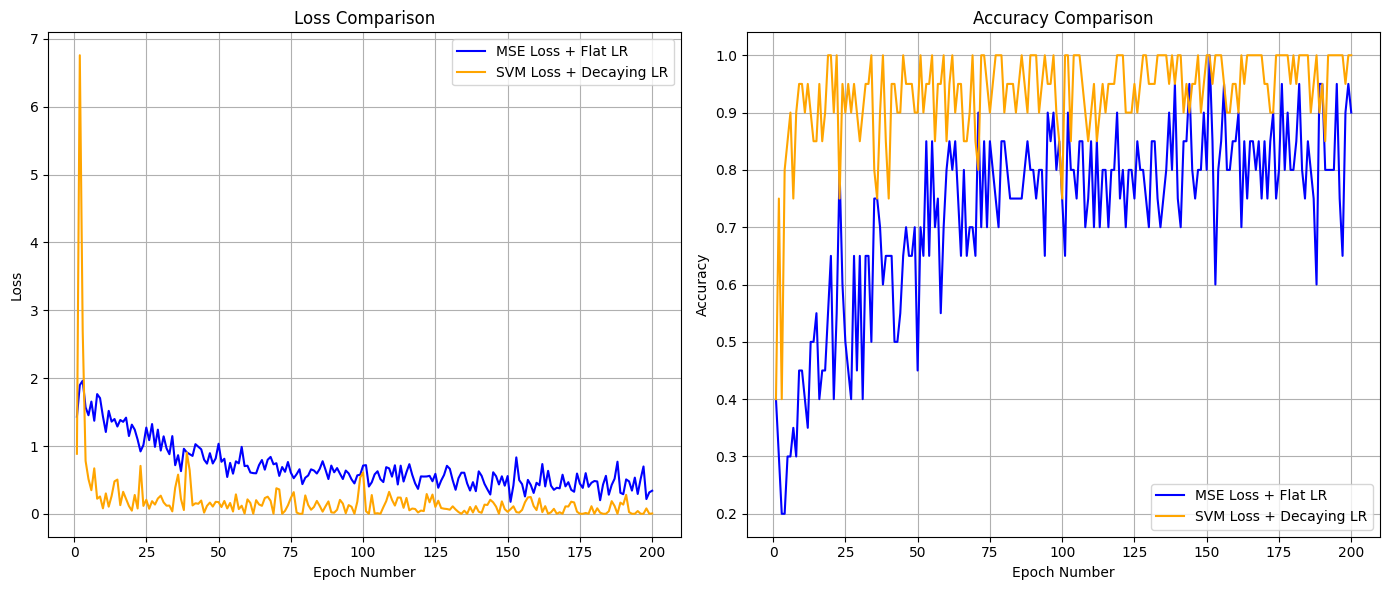

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
epoch_range = [x for x in range(1,num_epochs+1)]

axs[0].plot(epoch_range, mse_losses, label="MSE Loss + Flat LR", color='blue')
axs[0].plot(epoch_range, svm_losses, label="SVM Loss + Decaying LR", color='orange')
axs[0].set_title("Loss Comparison")
axs[0].set_xlabel("Epoch Number")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(epoch_range, mse_accuracies, label="MSE Loss + Flat LR", color='blue')
axs[1].plot(epoch_range, svm_accuracies, label="SVM Loss + Decaying LR", color='orange')
axs[1].set_title("Accuracy Comparison")
axs[1].set_xlabel("Epoch Number")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()

In [20]:
def visualise_boundaries(models: list[MLP], titles: list[str]):
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]

    fig, axs = plt.subplots(1, len(models), figsize=(14, 6))
    for i, (model, title) in enumerate(zip(models, titles)):
        # Compute predictions for the mesh grid
        inputs = [list(map(Value, xrow)) for xrow in Xmesh]
        scores = list(map(model, inputs))
        Z = np.array([s.data > 0 for s in scores])
        Z = Z.reshape(xx.shape)

        # Plot decision boundary
        axs[i].contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
        axs[i].contour(xx, yy, Z, colors='black', linewidths=1)
        axs[i].scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
        axs[i].set_title(title)
        axs[i].set_xlabel("Feature 1")
        axs[i].set_ylabel("Feature 2")
        axs[i].set_xlim(xx.min(), xx.max())
        axs[i].set_ylim(yy.min(), yy.max())

    plt.tight_layout()
    plt.show()


In [22]:
def visualise_one_boundary(model: MLP, title: str):
    h = 0.15
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.contour(xx, yy, Z, colors='black', linewidths=1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

## Traditional SVM with RBF Kernel

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm_classifier = SVC(kernel='rbf', gamma='auto', C=1.0)
svm_classifier.fit(X_train, y_train)

SVC(gamma='auto')

In [17]:
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy of SVM (RBF kernel): {accuracy*100:.2f}%")

Test Accuracy of SVM (RBF kernel): 95.00%


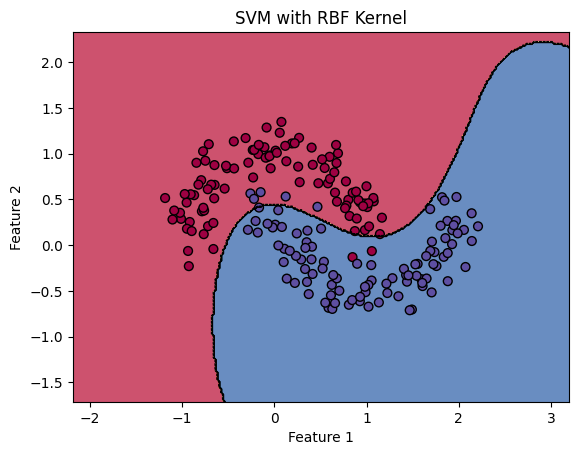

In [18]:
def plot_decision_boundary(classifier, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    Z = classifier.predict(Xmesh)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.contour(xx, yy, Z, colors='black', linewidths=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolor='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()


plot_decision_boundary(svm_classifier, X, y, title="SVM with RBF Kernel")


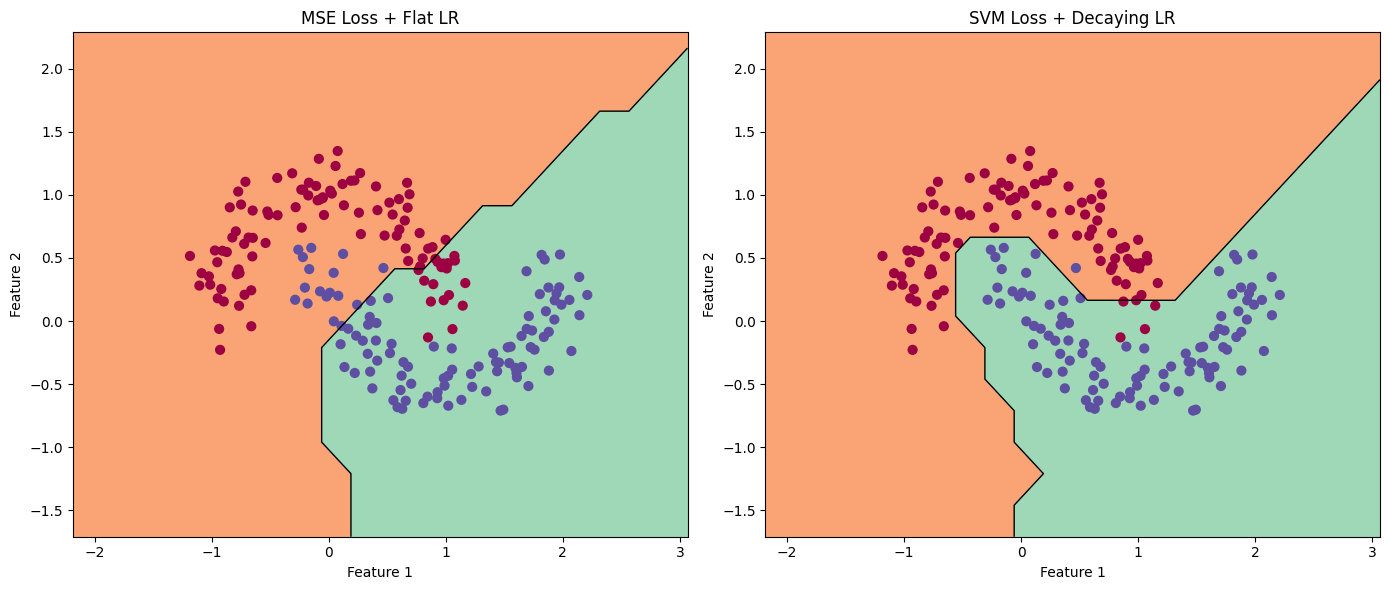

In [23]:
visualise_boundaries(
    models=[mse_loss_model, svm_loss_model],
    titles=["MSE Loss + Flat LR", "SVM Loss + Decaying LR"]
)